In [1]:
# 匯入相關所需的模組b
import os,sys
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from random import shuffle
os.environ['CUDA_VISIBLE_DEVICES']='0'
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import *
from keras.optimizers import *
from keras import utils as np_utils

def solve_cudnn_error():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e)

solve_cudnn_error()

1 Physical GPUs, 1 Logical GPUs


In [2]:
images=[]
labels=[]
name=[]


In [3]:
def read_images_labels(path,i):
    for file in os.listdir(path):
        abs_path=os.path.abspath(os.path.join(path,file))
        if os.path.isdir(abs_path):
            i+=1
            temp=os.path.split(abs_path)[-1]
            name.append(temp)
            read_images_labels(abs_path,i)
            amount=int(len(os.listdir(path)))
            sys.stdout.write('\r'+'>'*(i)+' '*(amount-i)+'[%s%%]'%(i*100/amount)+temp)
        else:
            if file.endswith('.jpg'):
                image = cv2.resize(cv2.imread(abs_path),(64,64))
                images.append(image)
                labels.append(i-1)
    return images, labels, name

In [4]:
def read_main(path):
    images, labels, name = read_images_labels(path,i=0)
    images=np.array(images,dtype=np.float32)/255
    labels=np_utils.to_categorical(labels, num_classes=20)
    np.savetxt('name.txt',name,delimiter=' ',fmt="%s")
    return images, labels

In [5]:
images,labels=read_main('simpsondata/train/characters-20')
X_train,X_test,Y_train,Y_test=train_test_split(images,labels,test_size=0.2)

>>>>>>>>>>>>>>>>>>>>[100.0%]ned_flandersownry_burns

In [6]:
print(images)

[[[[0.24705882 0.54901963 0.45490196]
   [0.24705882 0.54901963 0.45490196]
   [0.22745098 0.5294118  0.43529412]
   ...
   [0.12941177 0.43137255 0.40392157]
   [0.14901961 0.4509804  0.42352942]
   [0.14901961 0.4509804  0.42352942]]

  [[0.7490196  0.77254903 0.7294118 ]
   [0.7490196  0.77254903 0.7294118 ]
   [0.7254902  0.7490196  0.7058824 ]
   ...
   [0.22352941 0.59607846 0.35686275]
   [0.24313726 0.6156863  0.3764706 ]
   [0.24313726 0.6156863  0.3764706 ]]

  [[0.75686276 0.7647059  0.7411765 ]
   [0.7529412  0.7647059  0.7411765 ]
   [0.75686276 0.7647059  0.7411765 ]
   ...
   [0.25882354 0.5764706  0.38431373]
   [0.25882354 0.5764706  0.38431373]
   [0.25882354 0.5764706  0.38431373]]

  ...

  [[0.25882354 0.5686275  0.39607844]
   [0.25882354 0.5686275  0.39607844]
   [0.25882354 0.5686275  0.39607844]
   ...
   [0.27450982 0.54509807 0.3764706 ]
   [0.27450982 0.54509807 0.3764706 ]
   [0.27450982 0.54509807 0.3764706 ]]

  [[0.25882354 0.5686275  0.39607844]
   [0.2

In [7]:
labels[0]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.], dtype=float32)

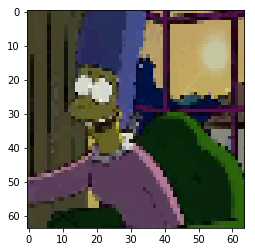

In [176]:
plt.imshow(X_train[1][:,:,[2,1,0]])

In [6]:
model = Sequential()
model.add(Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=X_train.shape[1:]))
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
    
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
    
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
    
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
    
model.add(Dense(20, activation='softmax'))
    

model.summary() # 秀出模型架構

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 64)        1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 256)       147712    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 256)       0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 256)       590080    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 256)       590080    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 256)       5

In [7]:
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True,mode='max')
callbacks_list= [checkpoint]

In [11]:
import time
def cal_runtime(Tin):
    endt=time.time()
    runt=endt-Tin
    runhr=int(int(runt/60)/60)
    runmin=int(runt/60)-(runhr*60)
    runsec=int(runt-runhr*3600-runmin*60)
    return("run time:"+str(runhr)+"h"+str(runmin)+"m"+str(runsec)+"s")
timetest=time.time()-3790
cal_runtime(timetest)

'run time:1h3m10s'

In [125]:
start=time.time()
epochs=20
batch_size=256
history = model.fit(X_train, Y_train,
         batch_size=batch_size,
         epochs=epochs,
         validation_data=(X_test, Y_test),
         shuffle=True,verbose=1,callbacks=callbacks_list)
print('\n'+cal_runtime(start))

Epoch 1/20
69/69 [==============================] - ETA: 0s - loss: 2.9757 - accuracy: 0.1072
Epoch 00001: val_accuracy improved from -inf to 0.10946, saving model to weights.best.hdf5
69/69 [==============================] - 34s 493ms/step - loss: 2.9757 - accuracy: 0.1072 - val_loss: 2.8776 - val_accuracy: 0.1095
Epoch 2/20
69/69 [==============================] - ETA: 0s - loss: 2.7917 - accuracy: 0.1381
Epoch 00002: val_accuracy improved from 0.10946 to 0.17852, saving model to weights.best.hdf5
69/69 [==============================] - 35s 504ms/step - loss: 2.7917 - accuracy: 0.1381 - val_loss: 2.6526 - val_accuracy: 0.1785
Epoch 3/20
69/69 [==============================] - ETA: 0s - loss: 2.3743 - accuracy: 0.2903
Epoch 00003: val_accuracy improved from 0.17852 to 0.43683, saving model to weights.best.hdf5
69/69 [==============================] - 36s 515ms/step - loss: 2.3743 - accuracy: 0.2903 - val_loss: 1.9108 - val_accuracy: 0.4368
Epoch 4/20
69/69 [=========================

In [126]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


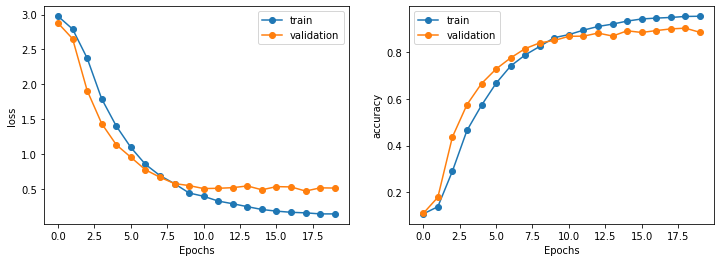

In [127]:
# 透過趨勢圖來觀察訓練與驗證的走向 (特別去觀察是否有"過擬合(overfitting)"的現象)
import matplotlib.pyplot as plt

def plot_train_history(history, train_metrics, val_metrics):
    plt.plot(history.history.get(train_metrics),'-o')
    plt.plot(history.history.get(val_metrics),'-o')
    plt.ylabel(train_metrics)
    plt.xlabel('Epochs')
    plt.legend(['train', 'validation'])
    
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plot_train_history(history, 'loss','val_loss')

plt.subplot(1,2,2)
plot_train_history(history, 'accuracy','val_accuracy')

plt.show()

In [16]:
epochs=555
batch_size=555

In [17]:
model.load_weights("weights.best.hdf5")
file_name="model_1_"+str(epochs)+"_"+str(batch_size)
model.save(file_name+'.h5')
score=model.evaluate(X_test,Y_test,verbose=1)
print(score)

62/62 [==============================] - 4s 61ms/step - loss: 0.0971 - accuracy: 0.9862
[0.09706036001443863, 0.9861892461776733]


In [11]:
import os 
DIR = 'simpsondata/test/test' #要統計的資料夾
image_len=len([name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))]) 
image_len

990

In [12]:
def read_images(path):
    test_images = []
    for i in range(image_len):
            img = cv2.resize(cv2.imread(path+str(i+1)+'.jpg'),(64,64))
            test_images.append(img)   
    test_images=np.array(test_images,dtype=np.float32)/255.
    return test_images

In [43]:
X_train,X_test,Y_train,Y_test=train_test_split(images,labels,test_size=0.5)

In [44]:
# 預測與比對
from keras.models import load_model

# 把訓練時val_loss最小的模型載入
model = load_model('model_1_alldata.h5')
#test_img=read_images('simpsondata/test/test/')
score=model.evaluate(X_test,Y_test,verbose=1)
# 預測與比對
# pred = model.predict_classes(test_img,verbose=1)
# #acc = np.sum(y_pred==np.argmax(y_valtest, axis=1))/np.size(y_pred)
# #print("Test accuracy = {}".format(acc))
# pred

306/306 [==============================] - 11s 36ms/step - loss: 0.0162 - accuracy: 0.9974


In [14]:
nametxt=np.loadtxt('name.txt',dtype='str')

name_label=[]
name_num=0
for i in nametxt:
    name_label.append([name_num,i])
    name_num+=1
name_label

[[0, 'edna_krabappel'],
 [1, 'abraham_grampa_simpson'],
 [2, 'mayor_quimby'],
 [3, 'chief_wiggum'],
 [4, 'principal_skinner'],
 [5, 'marge_simpson'],
 [6, 'bart_simpson'],
 [7, 'homer_simpson'],
 [8, 'apu_nahasapeemapetilon'],
 [9, 'lisa_simpson'],
 [10, 'lenny_leonard'],
 [11, 'milhouse_van_houten'],
 [12, 'charles_montgomery_burns'],
 [13, 'comic_book_guy'],
 [14, 'nelson_muntz'],
 [15, 'kent_brockman'],
 [16, 'sideshow_bob'],
 [17, 'moe_szyslak'],
 [18, 'krusty_the_clown'],
 [19, 'ned_flanders']]

In [25]:
new_pred=[]
for i in range(len(pred)):
    new_pred.append(name_label[pred[i]][1])
new_pred

['nelson_muntz',
 'kent_brockman',
 'ned_flanders',
 'ned_flanders',
 'krusty_the_clown',
 'lisa_simpson',
 'milhouse_van_houten',
 'moe_szyslak',
 'marge_simpson',
 'lenny_leonard',
 'milhouse_van_houten',
 'mayor_quimby',
 'principal_skinner',
 'lisa_simpson',
 'homer_simpson',
 'milhouse_van_houten',
 'mayor_quimby',
 'krusty_the_clown',
 'lenny_leonard',
 'kent_brockman',
 'krusty_the_clown',
 'bart_simpson',
 'krusty_the_clown',
 'homer_simpson',
 'bart_simpson',
 'abraham_grampa_simpson',
 'mayor_quimby',
 'lisa_simpson',
 'lenny_leonard',
 'milhouse_van_houten',
 'lenny_leonard',
 'homer_simpson',
 'apu_nahasapeemapetilon',
 'homer_simpson',
 'abraham_grampa_simpson',
 'homer_simpson',
 'marge_simpson',
 'charles_montgomery_burns',
 'charles_montgomery_burns',
 'milhouse_van_houten',
 'apu_nahasapeemapetilon',
 'charles_montgomery_burns',
 'chief_wiggum',
 'ned_flanders',
 'bart_simpson',
 'edna_krabappel',
 'marge_simpson',
 'apu_nahasapeemapetilon',
 'principal_skinner',
 'sid

In [26]:
with open('test1.csv','w+') as ans:
    ans.write('id,character\n')
    id=1
    for i in range(len(new_pred)):
        ans.write(str(id)+','+new_pred[i]+'\n')
        id+=1

In [27]:
# for layer in model.layers:
#     # check for convolutional layer
#     if 'conv' not in layer.name:
#         continue
#     filters, biases = layer.get_weights()
#     print(layer.name, filters.shape)
    
for i in range(len(model.layers)):
    layer = model.layers[i]
    # check for convolutional layer
    if 'conv' not in layer.name:
        continue
    # summarize output shape
    print(i, layer.name, layer.output.shape)

0 conv2d (None, 64, 64, 64)
1 conv2d_1 (None, 64, 64, 256)
4 conv2d_2 (None, 32, 32, 256)
5 conv2d_3 (None, 32, 32, 256)
6 conv2d_4 (None, 32, 32, 256)
9 conv2d_5 (None, 16, 16, 256)


In [70]:
os.environ["CUDA_VISIBLE_DEVICES"]='0'# retrieve weights from the second hidden layer
filters, biases = model.layers[0].get_weights()
# normalize filter values to 0-1 so we can visualize thxem
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
# plot first few filters
n_filters, ix = 256, 1
plt.figure(figsize=(20,50))
for i in range(n_filters):
    # get the filter
    f = filters[:, :, :, i]
    # plot each channel separately
    for j in range(3):
        # specify subplot and turn of axis
        ax = plt.subplot(n_filters, 13, ix)
        ax.set_xticks([])
        ax.set_yticks([])
            # plot filter channel in grayscale
        plt.imshow(f[:, :, j], cmap='blue')
        ix += 1
# show the figure
plt.show()

ValueError: Colormap blue is not recognized. Possible values are: Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, cividis, cividis_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag, flag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r, hot, hot_r, hsv, hsv_r, inferno, inferno_r, jet, jet_r, magma, magma_r, nipy_spectral, nipy_spectral_r, ocean, ocean_r, pink, pink_r, plasma, plasma_r, prism, prism_r, rainbow, rainbow_r, seismic, seismic_r, spring, spring_r, summer, summer_r, tab10, tab10_r, tab20, tab20_r, tab20b, tab20b_r, tab20c, tab20c_r, terrain, terrain_r, viridis, viridis_r, winter, winter_r

In [76]:
np.array(model.layers[0].get_weights()[0][:,:,1,:][1][2]).shape
model.layers[0].get_weights()

[array([[[[ 0.08048074, -0.12059792, -0.07242684, ..., -0.09736889,
            0.07578503,  0.11974826],
          [ 0.06090221, -0.09021201,  0.10478545, ..., -0.00837842,
            0.09855147, -0.01619394],
          [-0.05578138,  0.12354826, -0.05601471, ..., -0.03649378,
           -0.0678253 , -0.0146035 ]],
 
         [[ 0.10310587, -0.0005356 ,  0.04381972, ...,  0.08272504,
            0.00041999,  0.06263356],
          [-0.0801921 , -0.01435069,  0.08617767, ..., -0.08630437,
           -0.04938836, -0.08148756],
          [-0.09399725,  0.01480679,  0.09618508, ...,  0.06527616,
           -0.07951131, -0.03464759]],
 
         [[ 0.01079106,  0.06238537, -0.08683429, ..., -0.10163382,
           -0.0933465 ,  0.0585991 ],
          [ 0.01889037,  0.08036281, -0.05283054, ...,  0.01916675,
           -0.00060016, -0.06617074],
          [-0.02158514,  0.01027693,  0.06167289, ..., -0.02894978,
            0.00702327,  0.10140503]]],
 
 
        [[[-0.06278356, -0.1213805

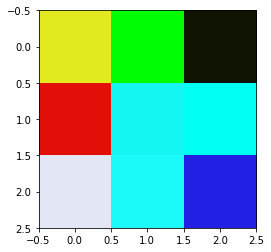

In [169]:
ft, bt=model.layers[0].get_weights()
ft1=ft[:,:,:,1]
rgb= (np.dstack((ft1[:,:,0],ft1[:,:,1],ft1[:,:,2])) * 255.999).astype(np.uint8)
plt.imshow(rgb)

In [129]:
(ft1[:,:,0]* 255.999).astype(np.uint8)

array([[ 20,  26,   2],
       [240,  27,   8],
       [247, 254,  15]], dtype=uint8)

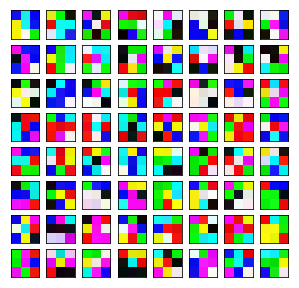

In [167]:
# retrieve weights from the second hidden layer
filters, biases = model.layers[0].get_weights()
# normalize filter values to 0-1 so we can visualize thxem
# f_min, f_max = filters.min(), filters.max()
# filters = (filters - f_min) / (f_max - f_min)
# plot first few filters
n_filters, ix = 64, 1
plt.figure(figsize=(5,40))
for i in range(n_filters):
    #for j in range(3):
    fj = filters[:, :, :, i]
    rgb= (np.dstack((fj[:,:,0],fj[:,:,1],fj[:,:,2])) * 255.999).astype(np.uint8)
    ax = plt.subplot(n_filters, 8, ix)
    ax.set_xticks([])
    ax.set_yticks([])
        # plot filter channel in grayscale
    plt.imshow(rgb,cmap='hsv')
    ix += 1
# show the figure
plt.show()

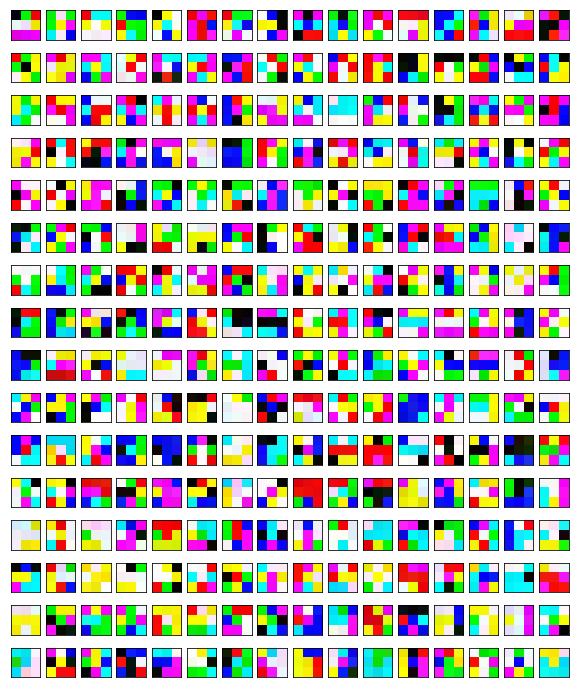

In [170]:
# retrieve weights from the second hidden layer
filters, biases = model.layers[1].get_weights()
# normalize filter values to 0-1 so we can visualize thxem
# f_min, f_max = filters.min(), filters.max()
# filters = (filters - f_min) / (f_max - f_min)
# plot first few filters
n_filters, ix = 256, 1
plt.figure(figsize=(10,200))
for i in range(n_filters):
    #for j in range(3):
    fj = filters[:, :, :, i]
    rgb= (np.dstack((fj[:,:,0],fj[:,:,1],fj[:,:,2])) * 255.999).astype(np.uint8)
    ax = plt.subplot(n_filters, 16, ix)
    ax.set_xticks([])
    ax.set_yticks([])
        # plot filter channel in grayscale
    plt.imshow(rgb)
    ix += 1
# show the figure
plt.show()

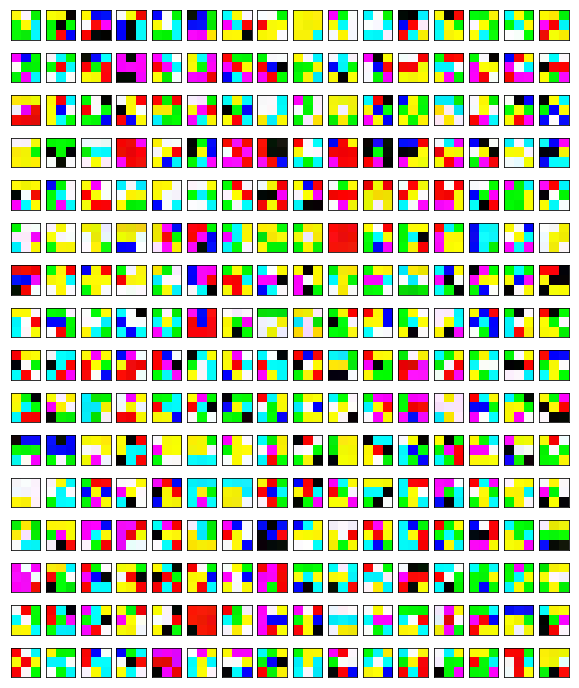

In [171]:
# retrieve weights from the second hidden layer
filters, biases = model.layers[4].get_weights()
# normalize filter values to 0-1 so we can visualize thxem
# f_min, f_max = filters.min(), filters.max()
# filters = (filters - f_min) / (f_max - f_min)
# plot first few filters
n_filters, ix = 256, 1
plt.figure(figsize=(10,200))
for i in range(n_filters):
    #for j in range(3):
    fj = filters[:, :, :, i]
    rgb= (np.dstack((fj[:,:,0],fj[:,:,1],fj[:,:,2])) * 255.999).astype(np.uint8)
    ax = plt.subplot(n_filters, 16, ix)
    ax.set_xticks([])
    ax.set_yticks([])
        # plot filter channel in grayscale
    plt.imshow(rgb)
    ix += 1
# show the figure
plt.show()

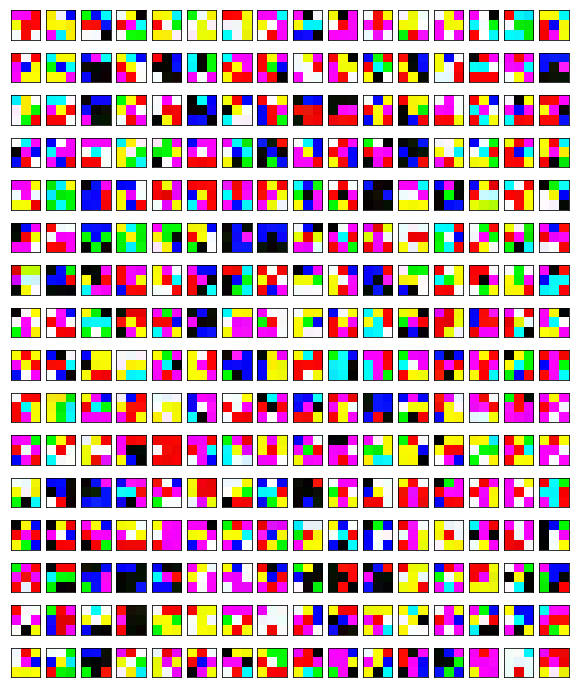

In [172]:
# retrieve weights from the second hidden layer
filters, biases = model.layers[5].get_weights()
# normalize filter values to 0-1 so we can visualize thxem
# f_min, f_max = filters.min(), filters.max()
# filters = (filters - f_min) / (f_max - f_min)
# plot first few filters
n_filters, ix = 256, 1
plt.figure(figsize=(10,200))
for i in range(n_filters):
    #for j in range(3):
    fj = filters[:, :, :, i]
    rgb= (np.dstack((fj[:,:,0],fj[:,:,1],fj[:,:,2])) * 255.999).astype(np.uint8)
    ax = plt.subplot(n_filters, 16, ix)
    ax.set_xticks([])
    ax.set_yticks([])
        # plot filter channel in grayscale
    plt.imshow(rgb)
    ix += 1
# show the figure
plt.show()

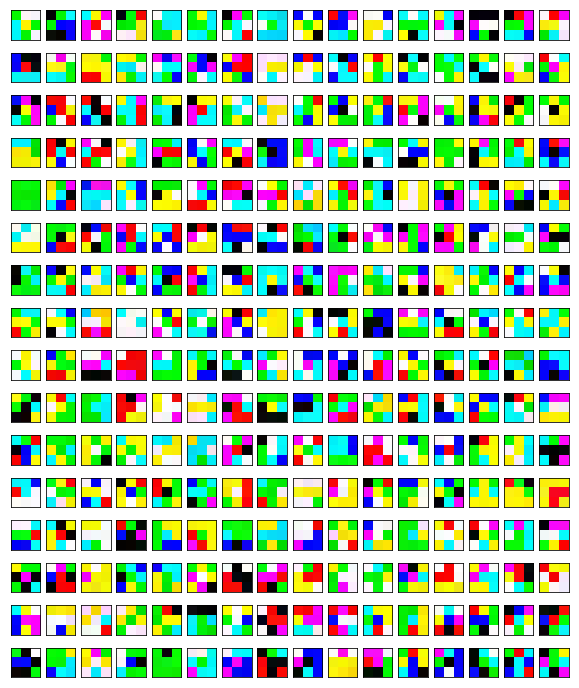

In [173]:
# retrieve weights from the second hidden layer
filters, biases = model.layers[6].get_weights()
# normalize filter values to 0-1 so we can visualize thxem
# f_min, f_max = filters.min(), filters.max()
# filters = (filters - f_min) / (f_max - f_min)
# plot first few filters
n_filters, ix = 256, 1
plt.figure(figsize=(10,200))
for i in range(n_filters):
    #for j in range(3):
    fj = filters[:, :, :, i]
    rgb= (np.dstack((fj[:,:,0],fj[:,:,1],fj[:,:,2])) * 255.999).astype(np.uint8)
    ax = plt.subplot(n_filters, 16, ix)
    ax.set_xticks([])
    ax.set_yticks([])
        # plot filter channel in grayscale
    plt.imshow(rgb)
    ix += 1
# show the figure
plt.show()

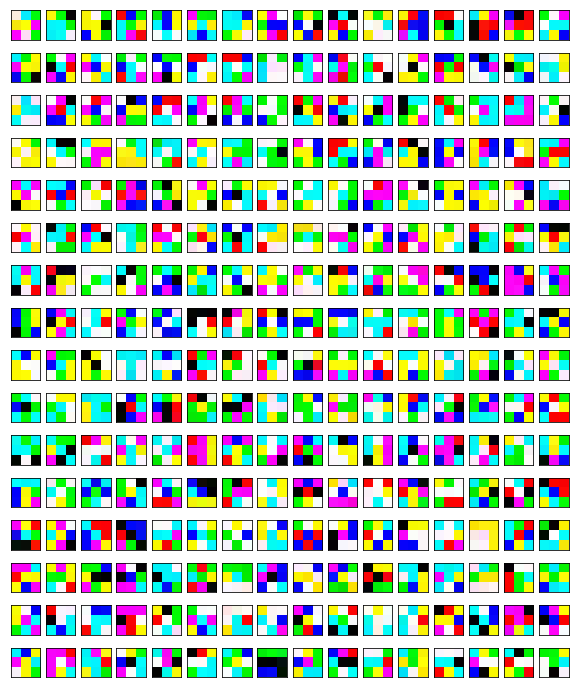

In [174]:
# retrieve weights from the second hidden layer
filters, biases = model.layers[9].get_weights()
# normalize filter values to 0-1 so we can visualize thxem
# f_min, f_max = filters.min(), filters.max()
# filters = (filters - f_min) / (f_max - f_min)
# plot first few filters
n_filters, ix = 256, 1
plt.figure(figsize=(10,200))
for i in range(n_filters):
    #for j in range(3):
    fj = filters[:, :, :, i]
    rgb= (np.dstack((fj[:,:,0],fj[:,:,1],fj[:,:,2])) * 255.999).astype(np.uint8)
    ax = plt.subplot(n_filters, 16, ix)
    ax.set_xticks([])
    ax.set_yticks([])
        # plot filter channel in grayscale
    plt.imshow(rgb)
    ix += 1
# show the figure
plt.show()

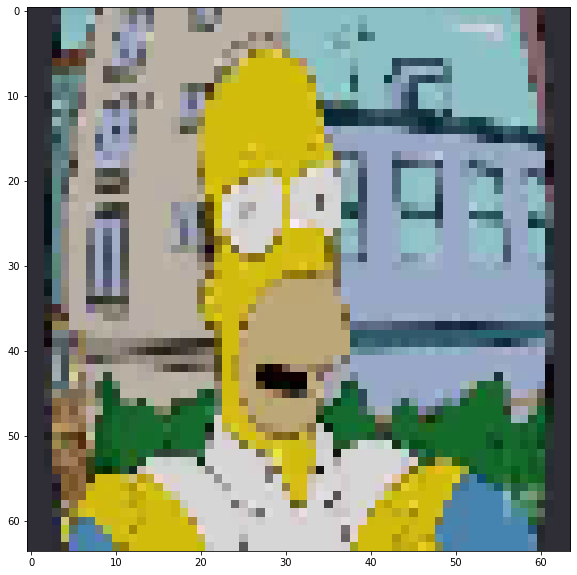

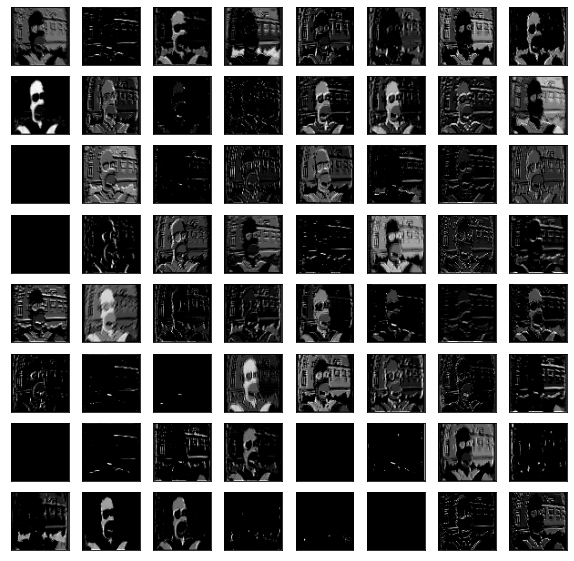

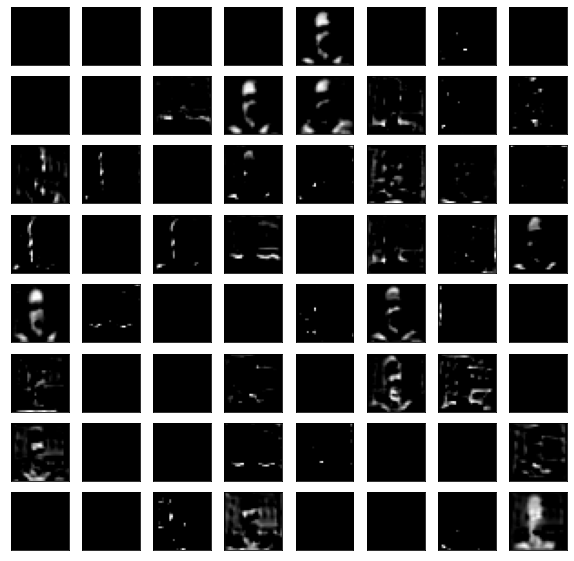

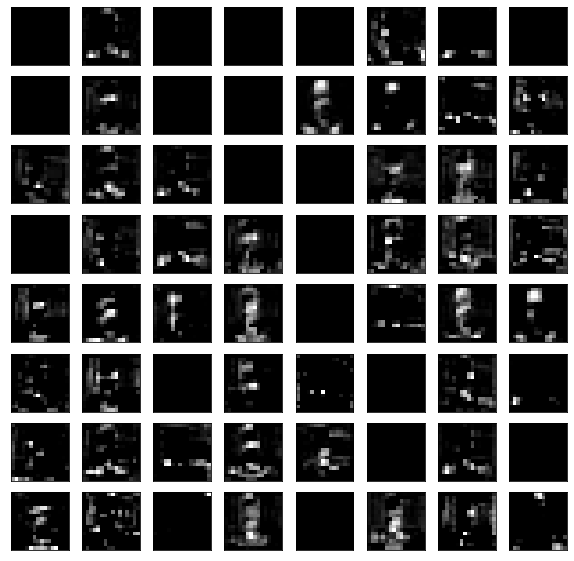

In [156]:
from keras.models import Model
from numpy import expand_dims
ixs = [0,1,4,5,6,9]
outputs = [model.layers[i].output for i in ixs]
model_f = Model(inputs=model.inputs, outputs=outputs)
# load the image with the required shape
img = X_train[1] #load_img('bird.jpg', target_size=(224, 224))
# convert the image to an array
# img = img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)
# prepare the image (e.g. scale pixel values for the vgg)
#img = preprocess_input(img)
# get feature map for first hidden layer
feature_maps = model_f.predict(img)
# plot the output from each block
square = 8
plt.figure(figsize=(10,10))
plt.imshow(img[0][:,:,[2,1,0]])
for fmap in feature_maps:
    # plot all 64 maps in an 8x8 squares
    ix = 1
    plt.figure(figsize=(10,10))
    for _ in range(square):
        for _ in range(square):
            # specify subplot and turn of axis
            ax = plt.subplot(square, square, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            # plot filter channel in grayscale
            plt.imshow(fmap[0, :, :, ix-1], cmap='gray')
            ix += 1
    # show the figure
    plt.show()


In [ ]:
X_train,X_test,Y_train,Y_test=train_test_split(images,labels,test_size=0.5)

In [149]:
print(X_test.shape)
# print(New_X_test[0])

(9774, 64, 64, 3)


(400, 64, 64, 3)
(400, 20)
[20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20.
 20. 20.]


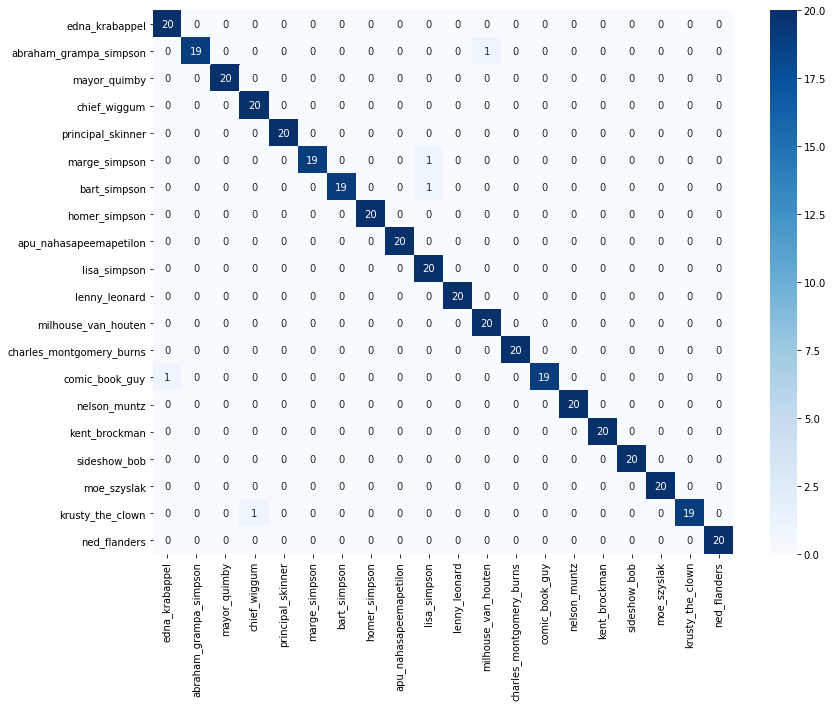

In [188]:
total_classcount=np.array([0 for _ in range(len(nametxt))]).astype(np.float)
New_X_test=[]
New_Y_test=[]
endata=True
while endata:
    endata=False
    w=np.random.randint(0,9774)
    for x in range(len(Y_test[w])):
         if int(Y_test[w][x]) > 0 :
            if total_classcount[x] < 20:
                total_classcount[x]+=1
                New_X_test.append(X_test[w])
                New_Y_test.append(Y_test[w])
    for z in total_classcount:
        endata=True if z < 20 else endata
New_X_test=np.array(New_X_test)
New_Y_test=np.array(New_Y_test)
print(New_X_test.shape)
print(New_Y_test.shape)
print(total_classcount)

val_pred=model.predict_classes(New_X_test)

Y_true=[]
ta=New_Y_test
for j in ta:
    c=0
    for i in j:
        if i==1.0:    
            Y_true.append(c)
            break
        else:
            c+=1
nametxt,Y_true

confusion_martix=np.array([[0 for _ in range(len(nametxt))] for _ in range(len(nametxt))]).astype(np.float)
total_classcount=np.array([0 for _ in range(len(nametxt))]).astype(np.float)
tp_martix=total_classcount
for a in range(len(Y_true)):
    total_classcount[Y_true[a]]+=1.0
    confusion_martix[Y_true[a]][val_pred[a]]+=1.0

import seaborn as sns
plt.figure(figsize=(13,10))
sns.heatmap(confusion_martix,cmap='Blues',annot=True, xticklabels=nametxt,yticklabels=nametxt)

Text(0.5,1,'confusion_martix')

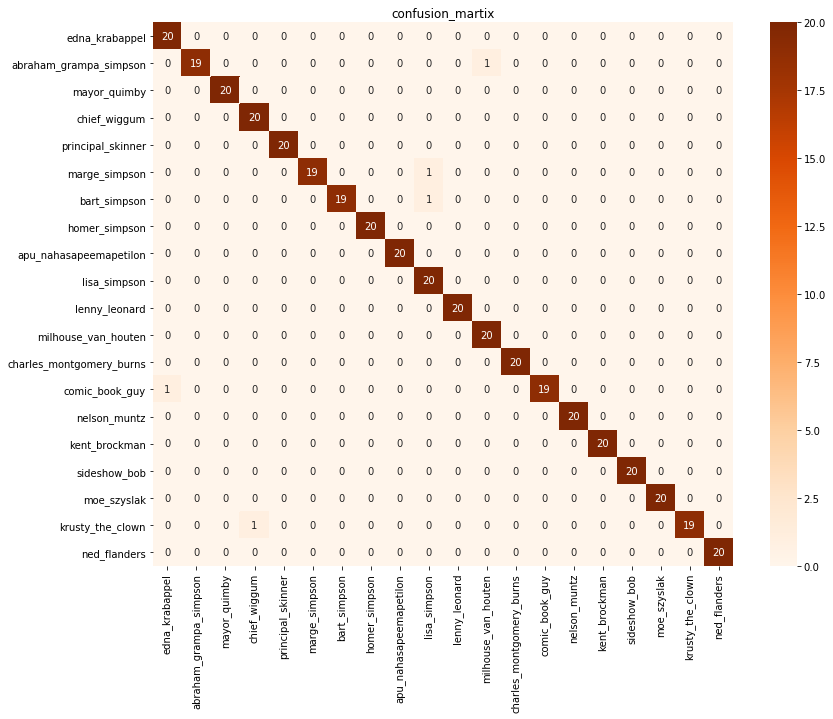

In [195]:
import seaborn as sns
plt.figure(figsize=(13,10))
sns.heatmap(confusion_martix,cmap='Oranges',annot=True, xticklabels=nametxt,yticklabels=nametxt)
plt.title("confusion_martix")

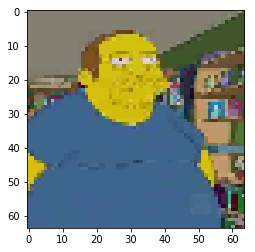

In [154]:
plt.imshow(New_X_test[4][:,:,[2,1,0]])

In [155]:
from sklearn import metrics
report = metrics.classification_report(Y_true, val_pred, target_names=nametxt)
print(report)

                          precision    recall  f1-score   support

          edna_krabappel       1.00      1.00      1.00        20
  abraham_grampa_simpson       1.00      0.95      0.97        20
            mayor_quimby       1.00      1.00      1.00        20
            chief_wiggum       1.00      1.00      1.00        20
       principal_skinner       1.00      1.00      1.00        20
           marge_simpson       1.00      1.00      1.00        20
            bart_simpson       1.00      1.00      1.00        20
           homer_simpson       1.00      1.00      1.00        20
  apu_nahasapeemapetilon       1.00      1.00      1.00        20
            lisa_simpson       1.00      1.00      1.00        20
           lenny_leonard       1.00      1.00      1.00        20
     milhouse_van_houten       0.95      1.00      0.98        20
charles_montgomery_burns       1.00      1.00      1.00        20
          comic_book_guy       1.00      1.00      1.00        20
         

In [156]:
len(New_Y_test)

400

In [189]:
with open("confusion_matrix.csv","w+") as cm:
    cm.write("Y_true,Y_pred\n")
    for i in range(len(Y_true)):
        wl=str(str(Y_true[i]) + ',' + str(val_pred[i]) + ','  + str(i) + ':' + nametxt[i] + '\n' )  if i < len(nametxt) else str(str(Y_true[i]) +','+ str(val_pred[i]) +'\n')
        cm.write(wl)